# Amazon apparel recommendation system 

In [13]:
#Importing the necessary pacakages

import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
from matplotlib import gridspec
import seaborn as sns
from collections import Counter
import itertools
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from PIL import Image
from io import BytesIO

# Data Overview

In [ ]:
#load json file using pandas
data = pd.read_json('tops_fashion.json')

In [ ]:
data.head()

In [ ]:
print ("number of data points {}, number of features {}".format(data.shape[0],data.shape[1]))

In [ ]:
#The number of features of each data point is 19
#name of each feature
data.columns

# Using pertinent features

In [ ]:
#as we are going to apply nlp on data['title'] in order to find out similarities between the products
#and the brand and the color of the product
#we remove the irrelavant feature data of the points
data = data[['asin','medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
#Reduced feature data
data.head()

# Exploatory data analysis

In [ ]:
print(data['product_type_name'].describe())

In [242]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [243]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [244]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [248]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [249]:
a = 28395/183138
print(a*100,'% of the total point have a listed price')

15.504701372735314 % of the total point have a listed price


In [250]:
data.to_pickle('Pickle/180k_apparel_data')
#Saving Data files

In [251]:
data = data[~data['formatted_price'].isnull()]
data.shape

(28395, 5)

In [252]:
#Removing the products with very few titles
#sorting the data alphabetically t
data = data[data['title'].apply(lambda x : len(x.split())>4)]
data.shape[0]

27958

In [253]:
data.to_pickle('Pickle/28k_apparel_data')

We have only relevant 28k out off 183k points. 


# Removing duplicate in titles

Please check commit for previous method used for data['title'] duplicates removal .

Removing duplicates using a better way which removes not just adjacent duplicate titles but same titles throughout the data unlike the previous method used.

Example :
Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt


In [254]:
data = pd.read_pickle('Pickle/28k_apparel_data')

In [255]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

asins1 = []
while len(indices)!=0:
    i = indices.pop()
    asins1.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a list
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in a list
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for h in itertools.zip_longest(a,b): 
            if (h[0]==h[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [256]:
data = data[data['asin'].isin(asins1)]

In [257]:
#data left after 
print("number of data points {}".format(data.shape[0]))

number of data points 16588


In [258]:
data.to_pickle('Pickle/16k_apparel_data')

## Text Preprocessing  

In [2]:
data = pd.read_pickle('Pickle/16k_apparel_data')

In [3]:
data.head()

,asin,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
27,B014ICEJ1Q,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95
60,B014ICB9A0,https://images-na.ssl-images-amazon.com/images...,APPAREL,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39


In [4]:
# we make a list of stopwords from nltk stopwords lib
stop_words = set(stopwords.words('english'))
print(list(stop_words))

['him', 'this', 'into', 'some', 'only', 'just', 'isn', 'he', 'having', 'between', 'be', 'until', 'd', "shan't", 'then', "hasn't", "haven't", 'or', 've', 'y', 'his', 'with', 'an', 'where', 'what', 'that', 'there', 'own', 'now', 'were', 'have', 'here', 'when', 'at', 'from', 'hers', 'for', 'during', "wouldn't", "mustn't", 'her', 'above', "should've", 'was', 'ma', 'nor', 'your', 'under', "you're", 'each', 'to', 'is', 'shouldn', "you've", 'very', 'haven', "wasn't", 'of', 'you', 'so', 'them', 'through', 's', "mightn't", 'whom', 'theirs', 'yourselves', 'while', 'should', 'hadn', 'these', "it's", 'who', 'they', 'didn', 'ourselves', 'will', "hadn't", 'few', 'yourself', 'does', 'ours', 'out', 'can', 'both', 'weren', 'themselves', 'm', 'itself', 'myself', 'no', "doesn't", 'and', 'if', 'about', 'than', 't', 'too', 'hasn', 'once', 'which', "she's", "didn't", "don't", 'did', 'wasn', 'doing', 'such', 'my', 'a', 'i', 'has', 'am', 'not', 'won', 'she', 'do', 'by', 'the', 'further', 'mustn', 'below', 'sh

In [5]:
def preprocessing(text,index,column):
    if type(text) is not int:
        string = ""
        for word in text.split():
            #removing special characters
            words = ("".join(i for i in word if i.isalnum()))
            #making all the words as lower case
            words = words.lower()
            #removal of stop words
            if words not in stop_words:
                string += words + " "
        data[column][index] = string     

In [6]:
for index,rows in data.iterrows():
    preprocessing(rows['title'],index,'title')

In [7]:
# Tried using stemmin on our titles, did not work well for our titles

In [8]:
data.to_pickle('Pickle/16k_nlp_processed_apparel_data')

In [14]:
data = pd.read_pickle('Pickle/16k_nlp_processed_apparel_data')

In [ ]:
#downloading all the images
from PIL import Image
import requests
from io import BytesIO

for index, row in data.iterrows():
        try:
            url = row['medium_image_url']
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.save('16k_images/'+row['asin']+'.jpeg')
        except:
            pass

# Text based product similarity

# Bag of words

In [62]:
# Building utility functions to be used throughout the workshop

#display an image
def display_img(url):
    #we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
#plotting to see the algorithms decision
def plot_heatmap(keys,values,labels,url,text):
    #keys gives us the list of words for recommended title
    
    #we will divide the figure into two parts
    gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
    fg = plt.figure(figsize=(25,3))
    
    #1st figure plotting a heatmap that represents the most commonly occuring words
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]),annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)
    
    #plotting the 2nd figure as image
    
    fg = plt.subplot(gs[1])
    fg.set_xticks([])
    fg.set_yticks([])
    fig = display_img(url)
    
    #display combine figure
    plt.show()

def plot_heat_map_image(doc_id,vec1,vec2,url,text,model):
    
    #doc_id : index of title1
    #vec1 : input apparels vector
    #vec2 : recommended apparels vector,
    #url : image url
    #text : title of the recommended title
    #model it can be any of the three models:
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
        
        
        intersection =  set(vec1.keys()) & set(vec2.keys())
        
        # we set the value of non intersecting word to zero in vec2
        for i in vec2.keys():
            if i not in intersection:
                vec2[i]=0
        # if ith word in intersection(list of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0
            values = [vec2[x] for x in vec2.keys()]
        # for labeling heat map
            keys = list(vec1.keys())
            
        if model == 'bag_of_words':
            labels = values
        elif model == 'tf_idf':
            labels = []
            for x in vec2.keys():
                #tfidf_title_vectorizer.vocabulary contains all the words in the corpus
                if x in idf_title_vectorizer.vocabulary_:
                    labels.append(idf_title_features[doc_id,tfidf_title_vectorizer.vocabulary_[x]])
                #for words not present int the corpus
                else:
                    labels.appens(0)
                    
                
        elif model == 'idf':
            labels =[]
            for x in vec2.keys():
                #idf_title_vectorizer.vocabulary contains all the words in the corpus
                if x in idf_title_vectorizer.vocabulary_:
                    labels.append(idf_title_features[doc_id,idf_title_vectorizer.vocabulary_[x]])
                #for words not present int the corpus
                else:   
                    labels.aapend(0)
        plot_heatmap(keys,values,labels,url,text)
        
        
                    
def text_to_vector_conversion(text):
    words = text.split()
    return Counter(words)

def results(doc_id,text1,text2,url,model):
    
    vector1 = text_to_vector_conversion(text1)
    vector2 = text_to_vector_conversion(text2)
    
    plot_heat_map_image(doc_id,vector1,vector2,url,text2,model)    

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_feature = title_vectorizer.fit_transform(data['title'])
# CountVectorizer().fit_transform(data['title']) returnsa sparse matrix with dimensions  =  no. points * words_in_corpus

title_feature.shape

(16588, 12745)

In [80]:
def bag_of_words_model(doc_id,cut_off):
    #doc_id is the number on the new index formed after CountVectorizer is applied to the data['title']
    #pairwise distance will save the distance between given input apparel and all other apparels
    pairwise_dist = pairwise_distances(title_feature,title_feature[doc_id])
    
    #np.argsort will return indices of the smallest distances
    indice = np.argsort(pairwise_dist.flatten())[0:cut_off]
    
    #get the index of the original dataframe
    data_indice = list(data.index[indice])
    
    for i in range(0,len(data_indice)):
        results(data_indice[i], data['title'].loc[data_indice[0]], data['title'].loc[data_indice[i]], data['medium_image_url'].loc[data_indice[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[data_indice[i]])

#try 12470
#try 12434

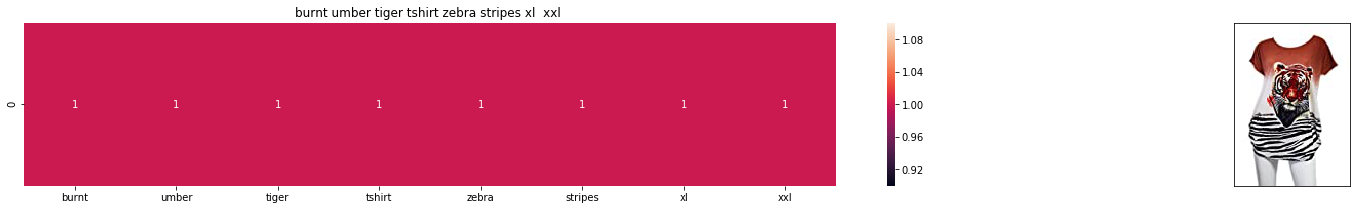

ASIN : B00JXQB5FQ


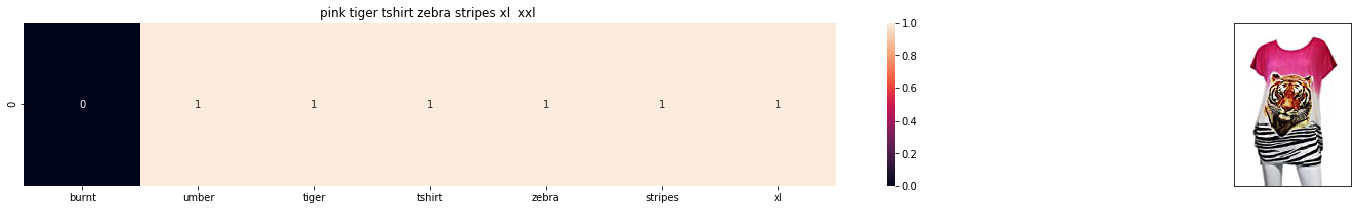

ASIN : B00JXQASS6


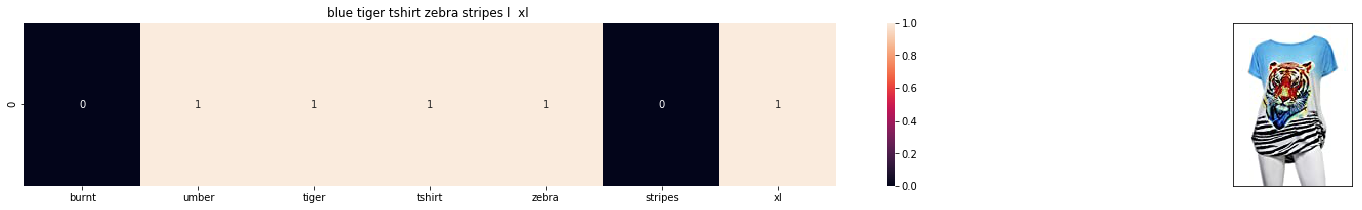

ASIN : B00JXQANA4


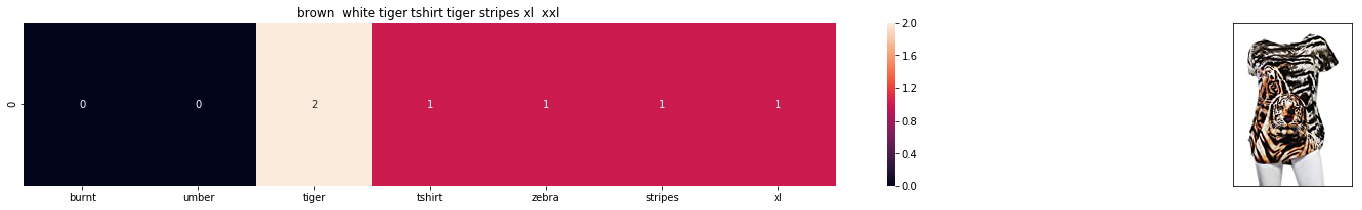

ASIN : B00JXQCWTO


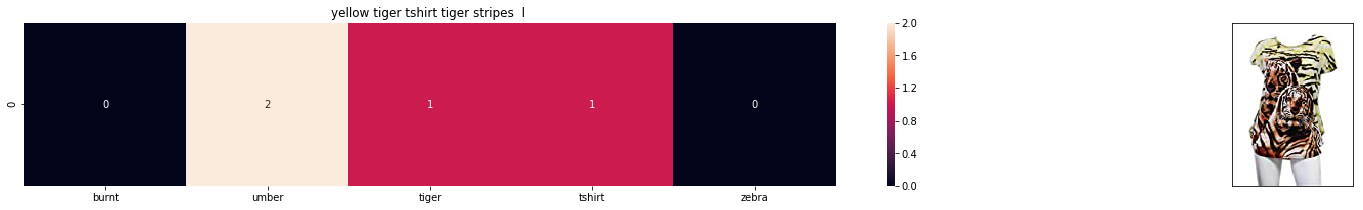

ASIN : B00JXQCUIC


In [81]:
bag_of_words_model(12434,5)